# Demonstration of Maze task using Agent Framework

In [1]:
import nxsdk.api.n2a as nx
import os
import matplotlib.pyplot as plt
import numpy as np
import sys
import pandas as pd

In [2]:
from gridAgent import *
from analysis_functions import *

Here we define the problem parameters: our agent navigates through a 5 x 5 grid in 2-D. The default location of the reward is the center of the environment (2,2). If it reaches this within a lifespan, it receives a reward. Otherwise, it is punished and re-initialized at a random location.

In [3]:
grid_x = 5
grid_y = 5
reward_location = (2,2)
lifespan = 8
dimensions = 2

n_states = grid_x * grid_y
n_actions = 4
n_estimates = n_states * n_actions
n_replicates = 2

In [4]:
t_epoch = 128
n_steps = 3000

In [5]:
agent = GridAgent(n_epochs=n_steps, n_replicates=n_replicates, reward_location=reward_location, lifespan=lifespan)

The agent exists on a 2-D toroid which it can move across using the cardinal directions (North, East, South, West). However, by default is constructed with 'walls' to force it into a rectangular environment. To do this, transitions from the outermost to innermost poloidal (N-S) and toroidal (E-W) points are forbidden (e.g. the agent cannot move E from location (4,0) and end up in (0,0)). 

Users can specify new 'walls' by appending them to the agent.walls list and calling agent.set_valid_transitions(). This reads the list of walls and updates the transitions forbidden to the agent.

In [6]:
agent.walls

[(0, 4, 'north'),
 (4, 0, 'east'),
 (1, 4, 'north'),
 (4, 1, 'east'),
 (2, 4, 'north'),
 (4, 2, 'east'),
 (3, 4, 'north'),
 (4, 3, 'east'),
 (4, 4, 'north'),
 (4, 4, 'east')]

In [7]:
#default walls create a rectangular environment
agent.transitions

array([[[1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0],
        [1, 1, 1, 1, 0]],

       [[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0]]])

In [8]:
results = []
runs = 1
for i in range(runs):
    results.append(agent.run())
agent.board.disconnect()

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:39631
INFO:DRV:      Host server up..............Done 0.34s
INFO:DRV:      Compiling Embedded snips....Done 0.45s
INFO:DRV:      Encoding axons/synapses.....Done 0.33s
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1599250663.982668/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:DRV:      Booting up..................Done 2.03s
INFO:HST:  Lakemont_driver...
INFO:DRV:      Encoding probes.............Done 1.31ms
INFO:DRV:      Transferring probes.........Done 3.29ms
INFO:DRV:      Configuring registers.......Done 0.13s
INFO:DRV:      Transferring spikes.........Done 0.98ms
INFO:HST:  chip=0 cpu=0 Setting up...
INFO:HST:  chip=0 cpu=0 Got variables
INFO:HST:  chip=0 cpu=0 Got R/P/State/Condition compartments
INFO:HST:  chip=0 cpu=0 Got Counter compartments
INFO:HST:  chip=0 cpu=0 Got estimate locs & values, done.
IN

Now, we can read out the data which shows the agent navigating through the environment.

In [9]:
hist = read_history(results[-1][0])

From this table, we can check the movements which the agent made at any point during the test and where it ended up.

In [10]:
hist[100:110]

,Action,X,Y
100,W,3,0
101,S,2,0
102,S,2,0
103,S,2,0
104,S,2,0
105,S,2,0
106,W,3,4
107,S,2,4
108,S,2,3
109,E,3,0


We can calculate the rewards the agent receives during navigation and use this to estimates its progress towards learning an optimal policy.

In [11]:
rewards = results[-1][1]
rwd_inds = rewards != 0
returns = rewards[rwd_inds]

Text(0,0.5,'Average Reward over 100 Epochs')

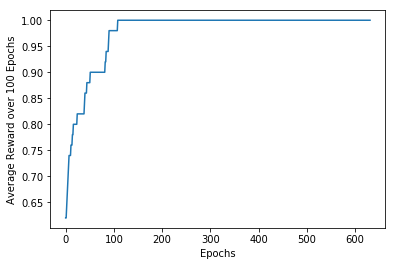

In [12]:
plt.plot(np.convolve(returns, np.ones(100),mode='valid')/100)
plt.xlabel("Epochs")
plt.ylabel("Average Reward over 100 Epochs")

By visualizing the greedy policy formed from the value estimates, we can see that the agent has indeed found an optimal policy. (Here, multiple optimal policies exist due to the length of the path taken not being considered). Following the policy seen below allows the agent to navigate to the reward from any position in the grid within the lifespan (8 steps).

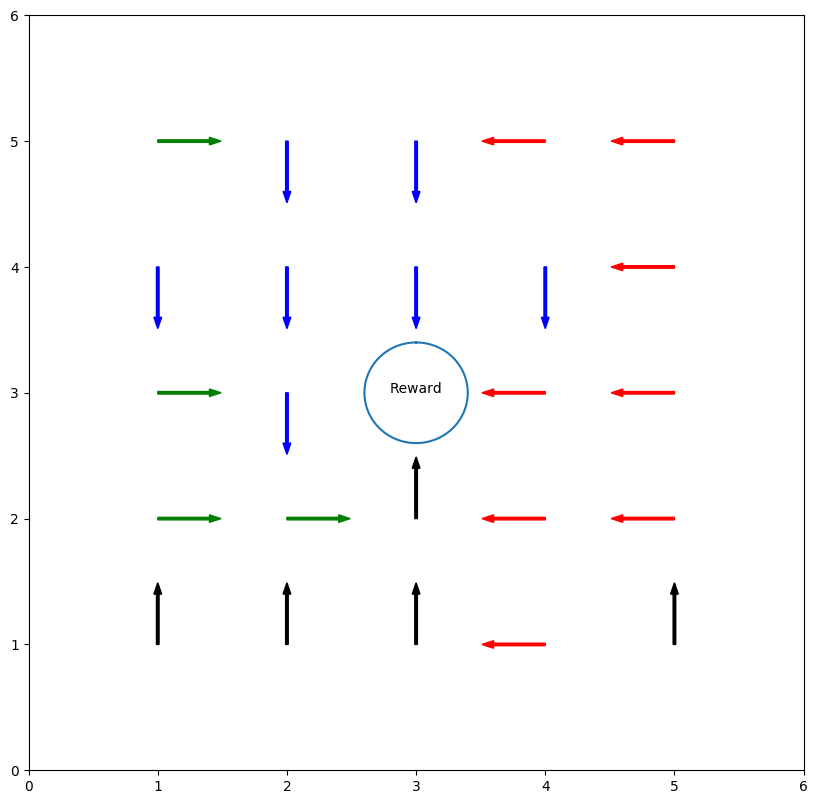

In [13]:
plot_values(agent.final_estimates, greedy=True)